# Classifier

In [1]:
import torch
from torch.utils.data import DataLoader

import pandas as pd 

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt 
import matplotlib.image as img

from models import *
from data_helpers import dataset

%matplotlib inline

In [2]:
# loading dataset
train = pd.read_csv('data/train.csv', header=None, names=['id','label'])
test = pd.read_csv('data/test.csv', header=None, names=['id','label'])

train_path = 'data/images/train/'
test_path = 'data/images/test/'

train.head()

,id,label
0,DOP25_LV03_1301_31_2015_1_15_499125.0_114812.5...,1
1,DOP25_LV03_1301_13_2015_1_15_499250.0_116187.5...,1
2,DOP25_LV03_1301_31_2015_1_15_497500.0_115750.0...,1
3,DOP25_LV03_1301_11_2015_1_15_498250.0_120875.0...,1
4,DOP25_LV03_1301_11_2015_1_15_497562.5_120750.0...,1


Total number of images in the Training Set:  654
Total number of images in the Test Set:  75


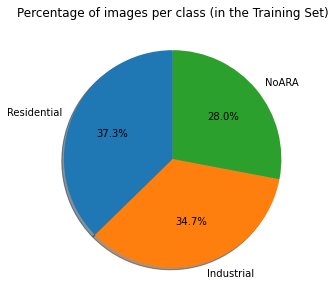

In [3]:
print('Total number of images in the Training Set: ', train.shape[0])
print('Total number of images in the Test Set: ', test.shape[0])

label = 'Residential', 'Industrial', 'NoARA'
plt.figure(figsize = (5,5))
plt.pie(train.groupby('label').size(), labels = label, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Percentage of images per class (in the Training Set)')
plt.show()

Residential: 


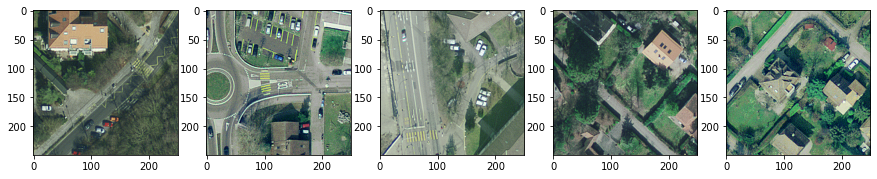

Industrial: 


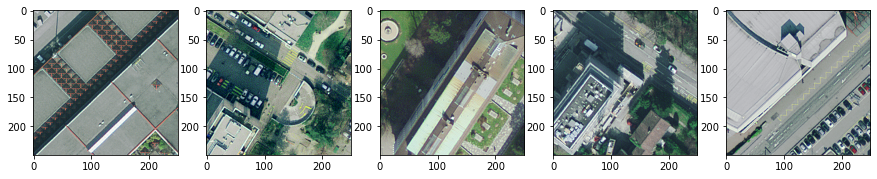

NoARA: 


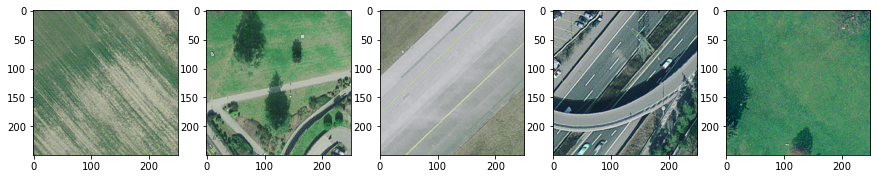

In [4]:
# Few examples

print('Residential: ')
fig,ax = plt.subplots(1,5,figsize = (15,3))
for i,idx in enumerate(train[train['label'] == 0]['id'][-5:]):
    path = os.path.join(train_path,idx)#+'.png'
    ax[i].imshow(img.imread(path))
plt.show()

print('Industrial: ')
fig,ax = plt.subplots(1,5,figsize = (15,3))
for i,idx in enumerate(train[train['label'] == 1]['id'][-5:]):
    path = os.path.join(train_path,idx)#+'.png'
    ax[i].imshow(img.imread(path))
plt.show()

print('NoARA: ')
fig,ax = plt.subplots(1,5,figsize = (15,3))
for i,idx in enumerate(train[train['label'] == 2]['id'][-5:]):
    path = os.path.join(train_path,idx)#+'.png'
    ax[i].imshow(img.imread(path))
plt.show()


In [5]:
# splitting train in train+valid
train, valid = train_test_split(train, stratify=train.label, test_size=0.5)

# get the images dataset access 
train_data = dataset(train, train_path)
valid_data = dataset(valid, train_path)
test_data = dataset(test, test_path)

In [6]:
# Hyper parameters
num_epochs = 10
num_classes = 3
batch_size = 4
learning_rate = 0.001

# set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device used: ", device.type)

Device used:  cpu
C:\Users\Riccardo\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [7]:
# data loeader
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle=False, num_workers=0)

In [8]:
# model
#model = ResNet().to(device)
model = CNN().to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=74420, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=3, bias=True)
)


In [ ]:
%%time
# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

In [ ]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
torch.save(model.state_dict(), 'models/model.ckpt')